# Retirement Investment Strategies
*Evaluating How to Allocate between Stocks and Bonds Based on Market History*

Inspired by [this reddit post](https://www.reddit.com/r/financialindependence/comments/5rni28/should_you_allocate_100_of_your_investments_to/).

NOTE: Data has been updated as of 12/2024. Some of the below commentary on figures, i.e. cumulative returns of stocks and bonds, may reference out-of-date figures.

#### Table of Contents:
* [Introduction](#intro)
* [Data Acquisition](#import)
* [Exploratory Analysis](#exploratory)
* [McQuarrie Indexes](#mcquarrie)
* [Portfolio Simulation](#simulation)
* [Conclusions](#conclusions)
* [References](#references)
* [Appendix](#appendix)

## Introduction <a class="anchor" id="intro"></a>

#### Portfolio Allocation
In most any portfolio, it is advisable to have a mix of assets. Let's use the common recommendation of a mix of stock and bonds. The advantage of adding bonds is that they provide fairly stable returns while being considered lower risk than stocks. Adding them to a portfolio lowers the  risk of the whole portfolio. The tradeoff for this lower risk profile is that they tend to provide lower returns. When the stock market crashes, a portfolio with a higher bond allocation will see a smaller drawdown. As you can imagine, this becomes very important to the person approaching or already in retirement. Their dependence on their portfolio for life's expenses tends to mean a lower tolerance for risk and drawdowns.

#### Purpose
The purpose of this report is to explore what portfolio allocations may provide the highest return by the time of retirement, without taking too much risk. We will rely on historical data for the US stock and bond markets. The investing period, also known as the accumulation phase, will be considered as 35 years (based on a person who begins investing at 30 and retires at 65).

#### Data
Stock and bond indexes will be used to understand market history. An index simply tracks the price of a basket of assets, representing an overall market or sector. For example, the S&P 500 index reflects the broader US stock market by tracking 500 company stocks.

To give the reader a bird's-eye view of market history, we will start by presenting a fairly widely used dataset compiled by economist Robert Schiller, showing the last 150 years of the S&P 500. For the body of the analysis, we will use a much more comprehensive dataset compiled by economist Edward McQuarrie in the last few years.

#### Note to the Reader

All of the graphs below have been generated using the Plotly library. Plotly is commonly used for visualizing financial and time-series data because it provides advanced features for doing so, particularly for viewing dense time series as we will. The reader may want to be aware of its key features beyond what matplotlib offers:
* You can hover over data points to see more information about them
* You can zoom in by selecting a region of the graph
* To return to the full view, double-click anywhere on the graph


In [ ]:
# The below can be used to ensure your environment will run the following notebook
# Python 3.7+ and Jupyter Lab 3+ are required
# NOTE: Jupyter server will need to be restarted after installing the requirements!

! pip3 install -r requirements.txt
! jupyter labextension install jupyterlab-plotly

# You will need Python 3.7+ and Java 8+ to use tabula
# Download Java here: https://www.java.com/en/download/manual.jsp

In [25]:
import os
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels
import plotly.express as px
import plotly.graph_objects as go
import tabula

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

## Data Acquisition<a class="anchor" id="import"></a>

In [26]:
# Schiller's dataset providing monthly S&P 500 prices from 1871 to 2018-04
data_url = 'https://datahub.io/core/s-and-p-500/r/data.csv'

# Save data in local file so it doesn't have to be reloaded from external sources
data_path = 'stocks.csv'

if os.path.exists(data_path): 
    # Read from file if we've already downloaded/aggregated the data
    data = pd.read_csv(data_path, index_col='Date')
    data.columns = ['Price']
    data.index = pd.to_datetime(data.index)

else:
    # Load data from Schiller's site
    data1 = pd.read_csv(data_url, index_col='Date')
    
    # Acquire remaining S&P500 data through 2022-03
    # The Yfinance module returns this data from Yahoo Finance in a DataFrame
    data2 = yf.download('^GSPC', start='2018-05-01', end='2022-03-01', interval='1mo')
    
    # Combine data from the above sources and save as CSV
    data = data1['SP500']
    data = data.append(data2['Close'])
    data.index = pd.to_datetime(data.index)
    data.to_csv('stocks.csv')

# View the first 3 and last 3 values of the dataset
data.head(3).append(data.tail(3))

,Price
Date,
1871-01-01,4
1871-02-01,4
1871-03-01,5
2022-01-01,4516
2022-02-01,4374
2022-03-01,4463


## Exploratory Analysis <a class="anchor" id="exploratory"></a>

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1815 entries, 1871-01-01 to 2022-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1815 non-null   float64
dtypes: float64(1)
memory usage: 28.4 KB


This is an extremely simple dataset. There are only two features - date and price. Over the 150-year span of the dataset, it has a total of 1815 values.

We can see the values are correctly detected as floats and there are no null values, meaning there is nothing else to do in preparing or cleaning this particular data. 

The reader may have seen stock price charts before, perhaps even the S&P 500. Most charts shown on television show only the current day's price. Presented below is something arguably much more interesting - US stock price history since the time of the Civil War!

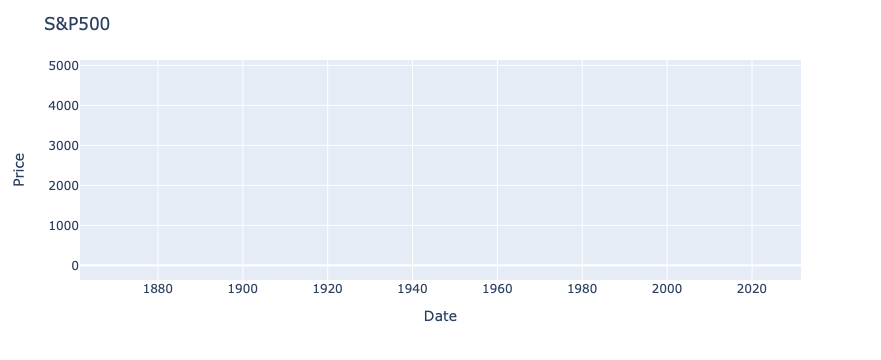

In [28]:
fig = px.scatter(data, x=data.index, y='Price')
fig.update_layout(title="S&P500")

In this view only the last 20 years are meaningful - the rest of the chart is wasted space. Over such a long timespan, we run into the issue that price spans many orders of magnitude. To correct for this, we will view the y-axis on a logarithmic scale.

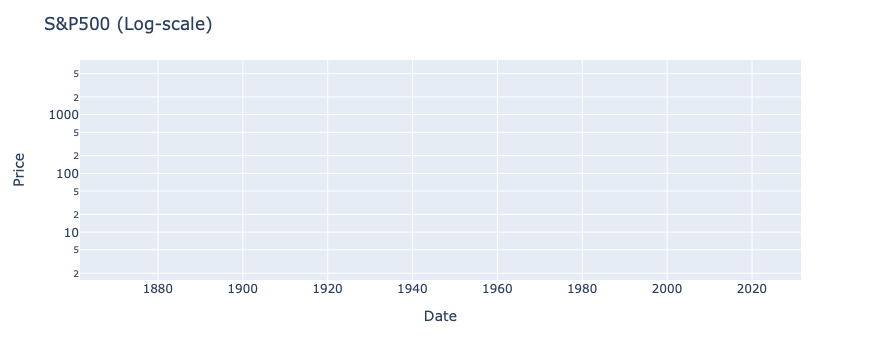

In [29]:
fig = px.scatter(data, x=data.index, y='Price', log_y=True)
fig.update_layout(title="S&P500 (Log-scale)")

It is fascinating to see a visualization of one of the most important facets of the global economy over the last 150 years. Already, we can observe trends. For the first 50 years, the trend appears to be almost flat. In today's environment of roughly 8% annual returns, it's almost impossible to imagine such a sleepy market.

The Roaring 20's and the subsequent Great Depression stand out, as does the "double-hump" of the 2000's, where the dot-com bubble crashed and then a few years later we saw the Great Recession.

The reader is welcome to further explore time periods of interest to him or her by zooming in on them above. Remember, this can be done by selecting the region with your mouse or trackpad.

## The McQuarrie Indexes <a class="anchor" id="mcquarrie"></a>

The above data provides a basic overview but will not be nearly enough to address our research question. It does not include inflation, which will need to be accounted for. Nor does it include bonds. Finally, as we will be testing 35-year periods at a time, we desire as much market history as possible, to test the most periods. A larger dataset would be highly desirable.

Thankfully, in the past year Edward McQuarrie has published US stock and bond indexes going back to 1793. This remarkable feat was accomplished through examining digital archives of newspapers for daily reports of market performance. I am extremely grateful to his work for making the following analysis possible. 

McQuarrie (2021) included these indexes in the appendices. Our next task will be to parse the data these tables in the PDF version of his paper. This can be accomplished with Tabula library.

There are 6 tables in total, which will be imported as 6 DataFrames by tabula, then returned as a list of those DataFrames.

In [30]:
# NOTE: McQuarrie's paper in PDF format will need to be loaded into the current Jupyter directory
# It was included in this report but can also downloaded from https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3805927

# Tabula will return a list containing a DataFrame for every detected table
dfs = tabula.read_pdf('SSRN-id3805927.pdf', pages='38-40', pandas_options={'header': None})

#Display the first DataFrame
dfs[0].head()

,0,1,2,3
0,To\rJanu-\rary of:,Infla-\rtion,Nomi-\rnal\rstocks,Nomi-\rnal\rbonds
1,1794,7.3%,-7.64%,-7.24%
2,1795,12.8%,19.81%,15.32%
3,1796,9.5%,9.90%,-1.03%
4,1797,0.6%,-3.50%,-6.10%


A fair amount of cleanup and parsing will need to be done.

In [31]:
# Remove row with header information in first DataFrame
dfs[0] = dfs[0][1:]

# The last 2 DataFrames were detected as a single double-wide DataFrame (dfs[4])
# They need to be separated
df_4 = dfs[4].loc[:, :3]
df_5 = dfs[4].loc[:, 4:]

# Set df_5 column names to match others so concat will work below
df_5.columns = [0, 1, 2, 3]

# Merge DataFrames vertically
df = pd.concat([dfs[0], dfs[1], dfs[2], dfs[3], df_4, df_5])

df.columns = ['Year', 'Inflation', 'Stocks', 'Bonds']

# Remove final row containing only NaNs
df = df[:-1]

# Clean up year values showing decimals at end
df['Year'] = df['Year'].astype('int')

df = df.set_index('Year')
df.index = pd.to_datetime(df.index, format='%Y')

# Remove % at end of values and cast values to floats
for col in df.columns:
    df[col] = df[col].str.strip('%')
    df[col] = df[col].astype('float')

# Voila    
df

,Inflation,Stocks,Bonds
Year,,,
1794-01-01,7,-8,-7
1795-01-01,13,20,15
1796-01-01,10,10,-1
1797-01-01,1,-4,-6
1798-01-01,-4,13,15
...,...,...,...
2015-01-01,-0,11,20
2016-01-01,1,-5,-6
2017-01-01,2,22,6


McQuarrie has calculated annual returns from January of each year from 1794 to 2019. Unlike the data we worked with above, which showed the prices of the index, McQuarrie's data indicates the annual return, including dividends, as a percentage. This will be more useful for our purposes in simulating portfolio returns.

We will update the data to include 2020, 2021 and 2022. As noted in the appendix of his paper, McQuarrie used the CPI-U index for inflation data. Values for this can be found on the Deparment of Labor's website. He used the CSRP index for recent stock data and the SBBI index for recent bond data. Unfortunately, these indices are not available without a paid subscription. Therefore, substitutions had to be made. 

S&P 500 data (ticker ^GSPC) will be used in place of the CSRP index, as both represent the total US stock market. The S&P 500 is the publicly available index containing the largest number of companies and therefore is the best proxy.

Bond data will be drawn from the PIMCO Investment Grade Corporate Bond index (ticker CORP), as this is fairly close to the SBBI index and the corporate bonds that comprise it.

These substitutions are not ideal, but because it is used for only 3 years out of 229, the tradeoff is considered acceptable. Using them also makes it possible for the reader to view the price action of the last 3 years in light of historical trends.

In [32]:
# Create a new DataFrame for 2020 - 2022 values
df2 = pd.DataFrame(columns=['Inflation', 'Stocks', 'Bonds'])
df2.index = pd.to_datetime(df2.index)

# Create new year indices and initialize data with NaNs
df2.loc[pd.to_datetime('2020')] = [np.nan for x in range(3)]
df2.loc[pd.to_datetime('2021')] = [np.nan for x in range(3)]
df2.loc[pd.to_datetime('2022')] = [np.nan for x in range(3)]
df2.loc[pd.to_datetime('2023')] = [np.nan for x in range(3)]
df2.loc[pd.to_datetime('2024')] = [np.nan for x in range(3)]
df2.loc[pd.to_datetime('2025')] = [np.nan for x in range(3)]

# Inflation rates taken from the Department of Labor Statistics 
df2.loc['2020-01-01']['Inflation'] = 2.3
df2.loc['2021-01-01']['Inflation'] = 1.4
df2.loc['2022-01-01']['Inflation'] = 7.5
df2.loc['2023-01-01']['Inflation'] = 6.5
df2.loc['2024-01-01']['Inflation'] = 3.4
df2.loc['2025-01-01']['Inflation'] = 2.7

# Add stock data
df3 = yf.download('^GSPC', start='2019-01-01', end='2025-01-01', interval='3mo')
df3 = df3['Close']

# Convert downloaded data to gain/loss and add to df2 dataframe
df2.loc['2020-01-01']['Stocks'] = (df3.loc['2020-01-01'] / df3.loc['2019-01-01'] - 1) * 100
df2.loc['2021-01-01']['Stocks'] = (df3.loc['2021-01-01'] / df3.loc['2020-01-01'] - 1) * 100
df2.loc['2022-01-01']['Stocks'] = (df3.loc['2022-01-01'] / df3.loc['2021-01-01'] - 1) * 100
df2.loc['2023-01-01']['Stocks'] = (df3.loc['2023-01-01'] / df3.loc['2022-01-01'] - 1) * 100
df2.loc['2024-01-01']['Stocks'] = (df3.loc['2024-01-01'] / df3.loc['2023-01-01'] - 1) * 100
df2.loc['2025-01-01']['Stocks'] = (df3.loc['2024-12-19'] / df3.loc['2024-01-01'] - 1) * 100

# Add bond data
df3 = yf.download('CORP', start='2019-01-01', end='2025-01-01', interval='3mo')
df3 = df3['Close']

# Convert downloaded data to gain/loss and add to df2 dataframe
df2.loc['2020-01-01']['Bonds'] = (df3.loc['2020-01-01'] / df3.loc['2019-01-01'] - 1) * 100
df2.loc['2021-01-01']['Bonds'] = (df3.loc['2021-01-01'] / df3.loc['2020-01-01'] - 1) * 100
df2.loc['2022-01-01']['Bonds'] = (df3.loc['2022-01-01'] / df3.loc['2021-01-01'] - 1) * 100
df2.loc['2023-01-01']['Bonds'] = (df3.loc['2023-01-01'] / df3.loc['2022-01-01'] - 1) * 100
df2.loc['2024-01-01']['Bonds'] = (df3.loc['2024-01-01'] / df3.loc['2023-01-01'] - 1) * 100
df2.loc['2025-01-01']['Bonds'] = (df3.loc['2024-12-19'] / df3.loc['2024-01-01'] - 1) * 100

df2

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Inflation,Stocks,Bonds
2020-01-01,2,-9,2
2021-01-01,1,54,5
2022-01-01,8,14,-7
2023-01-01,6,-9,-8
2024-01-01,3,28,-0
2025-01-01,3,12,-1


In [33]:
df = df.append(df2)
df.index = df.index.rename('Year')
df

,Inflation,Stocks,Bonds
Year,,,
1794-01-01,7,-8,-7
1795-01-01,13,20,15
1796-01-01,10,10,-1
1797-01-01,1,-4,-6
1798-01-01,-4,13,15
...,...,...,...
2021-01-01,1,54,5
2022-01-01,8,14,-7
2023-01-01,6,-9,-8


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 1794-01-01 to 2025-01-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inflation  232 non-null    float64
 1   Stocks     232 non-null    float64
 2   Bonds      232 non-null    float64
dtypes: float64(3)
memory usage: 7.2 KB


We do not have any null values and the data were correctly detected as floats.

In [35]:
df.describe()

,Inflation,Stocks,Bonds
count,232,232,232
mean,2,9,6
std,5,17,8
min,-11,-48,-23
25%,-1,-2,2
50%,1,8,5
75%,3,19,9
max,25,76,50


For the first time, we can now glean some of the insights of this incredibly powerful dataset. 

For example, the above shows that the median inflation rate over the United States' lifetime has been 1.3%.

Even more interestingly, stocks have returned a median of 8.1% annually while bonds yielded 5.5%.

These are some of the two most important datapoints in this analysis. In fact, it may seem as though our research question has been answered. To maximize the size of our investment portfolio by retirement, we should invest it primarily if not entirely in stocks. 

Of course, the reality is more complicated than this. No one accumulates a portfolio over such a long timeframe! We need to see how markets have fared over 35-year periods. In addition, we need to adjust these returns for inflation.

In [36]:
# Inflation-adjusted yields
df['Stocks_adj'] = (1 + df['Stocks']) / (1 + df['Inflation']) - 1
df['Bonds_adj'] = (1 + df['Bonds']) / (1 + df['Inflation']) - 1

# Calculate cumulative values so total returns can be determined

# Cumulative inflation
df['Inflation_cum'] = (df['Inflation']/100 + 1).cumprod()

# Cumulative stock yields
df['Stocks_cum'] = (df['Stocks']/100 + 1).cumprod()
df['Stocks_cum'] = df['Stocks_cum'].astype('float64')
df['Stocks_cum_adj'] = df['Stocks_cum'] / df['Inflation_cum'] # Adjust for inflation

# Cumulative bond yields
df['Bonds_cum'] = (df['Bonds']/100 + 1).cumprod()
df['Bonds_cum'] = df['Bonds_cum'].astype('float64')
df['Bonds_cum_adj'] = df['Bonds_cum'] / df['Inflation_cum'] # Adjust for inflation

df

,Inflation,Stocks,Bonds,Stocks_adj,Bonds_adj,Inflation_cum,Stocks_cum,Stocks_cum_adj,Bonds_cum,Bonds_cum_adj
Year,,,,,,,,,,
1794-01-01,7,-8,-7,-2,-2,1,1,1,1,1
1795-01-01,13,20,15,1,0,1,1,1,1,1
1796-01-01,10,10,-1,0,-1,1,1,1,1,1
1797-01-01,1,-4,-6,-3,-4,1,1,1,1,1
1798-01-01,-4,13,15,-7,-8,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2021-01-01,1,54,5,22,2,27,21105981,786297,260067,9689
2022-01-01,8,14,-7,1,-2,29,24067808,834083,243096,8425
2023-01-01,6,-9,-8,-2,-2,31,21830713,710381,224562,7307


## Exploratory Analysis: Part 2

### Inflation

1 US dollar from 1793 would be worth about 29 dollars today (from the inflation_cum column above). This value is nearly identical to what [inflation calculators](https://www.officialdata.org/us/inflation/1793?endYear=2019&amount=1) on the internet show, so we will take this as validation of the above calculations.

Now to view the journey inflation rates took to get here.

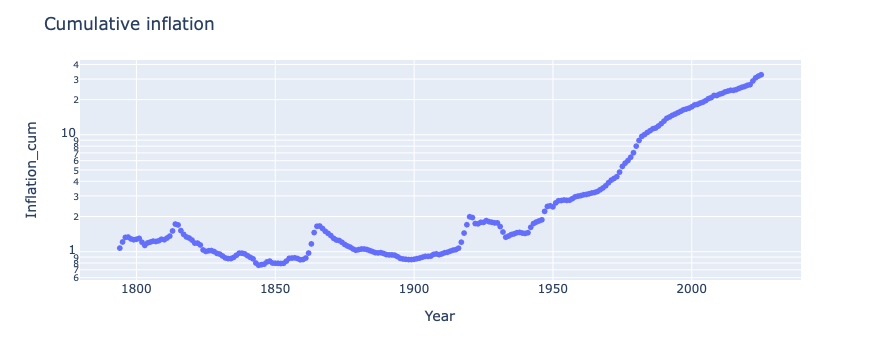

In [37]:
fig = px.scatter(df, x=df.index, y='Inflation_cum', log_y=True)
fig.update_layout(title="Cumulative inflation")

A few things are notable from the above chart:

*Deflationary periods*<br>
In today's environment of 7% inflation, it's hard to imagine there was ever a time where the trend was deflationary rather than inflationary. However, prior to 1935, we can see 3 long periods of deflation of the US dollar. During that time any value stored in US dollars appreciated over time, rather than depreciated. This means individuals storing their savings in dollars were rewarded by seeing the value of their savings increase. Today, the opposite is true: any value stored in dollars rapidly erodes, encouraging individuals and companies to store their value in assets.

*Stability of the dollar*<br>
Due to the above balance between inflationary and deflationary periods, over most of the United States' history, the dollar's value stayed relatively stable at between 50 to 100% of the 1793 value. 

In 1950 we see inflation break this barrier and increase unabatedly into the future. What factors lead to this? Where will it go from here? This is a fantastic topic for further research, but beyond the scope of this paper.

## Stocks

The below chart shows the hypothetical return of 1 dollar invested in 1793 through the start of 2022. This does not adjust for inflation and is referred to as the nominal return. 

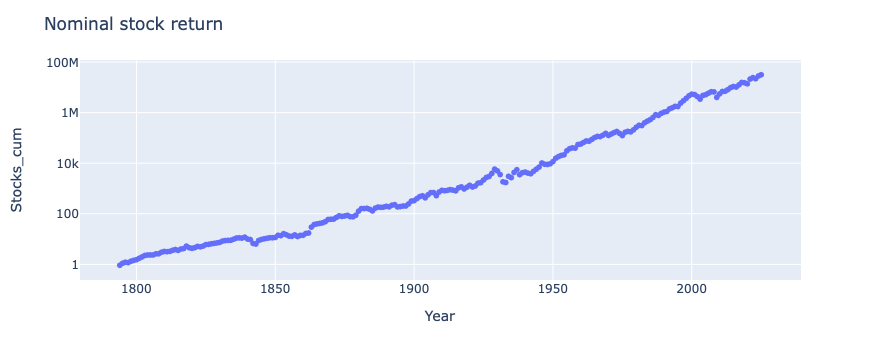

In [14]:
fig = px.scatter(df, x=df.index, y='Stocks_cum', log_y=True)
fig.update_layout(title="Nominal stock return")

This is not very useful, because we know from above that inflation has depreciated the value of the dollar. Therefore, we will show the stock market's value adjusted for inflation - its real returns.

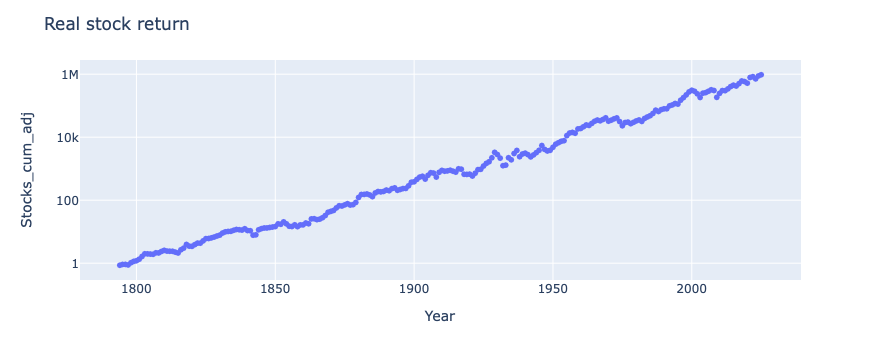

In [15]:
fig = px.scatter(df, x=df.index, y='Stocks_cum_adj', log_y=True)
fig.update_layout(title="Real stock return")

Interestingly, we see a roughly linear trend of appreciation from the above chart. This is arguably assuring, given that we have taken the longest timeframe available data allows, and it shows a fairly consistent march of increase.

Linear growth within a logarithmic space (remember, the above chart displays the log of the y-axis) means that stock returns are growing exponentially. In other words a full stock portfolio would have historically doubled every set number of years. In this case, we can use the [Rule of 72](https://www.investopedia.com/terms/r/ruleof72.asp) and our median yield of 8% per year to determine that the market doubles every 72 / 8 = 9 years.

The plotly library supports regression out of the box. Given that trendline appears linear when the y-axis is logarithmically transformed, let's see how log-linear regression fares.

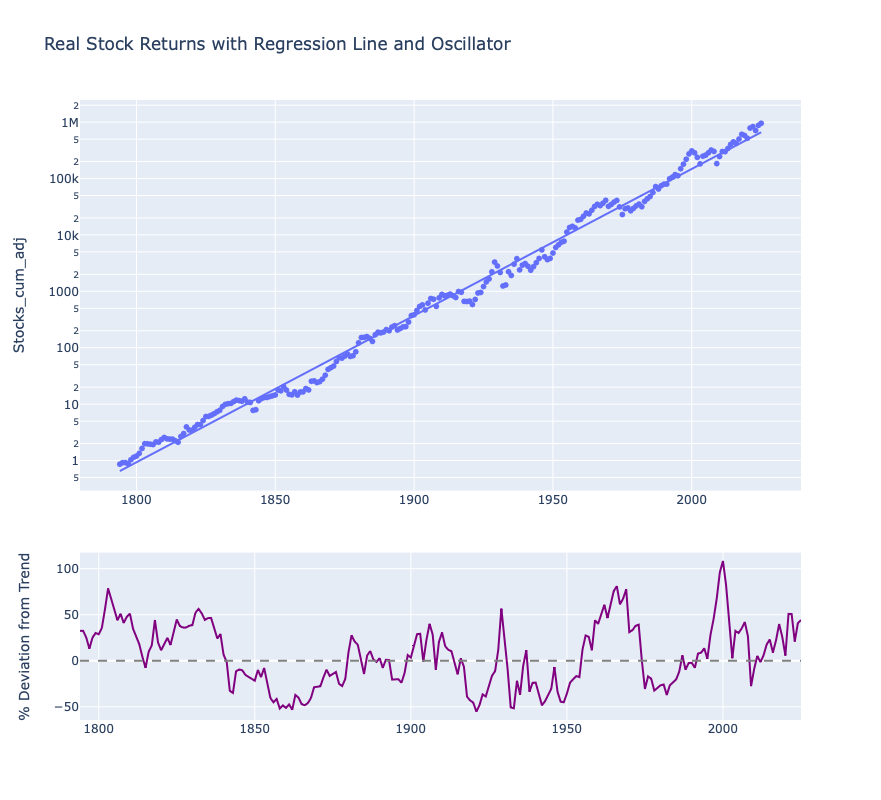

In [46]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Create figure with secondary y-axis
fig = make_subplots(rows=2, cols=1, 
                   row_heights=[0.7, 0.3],
                   vertical_spacing=0.1)

# Add scatter plot to the top subplot
scatter = px.scatter(df, x=df.index, y='Stocks_cum_adj', log_y=True, trendline="ols", 
                    trendline_options=dict(log_y=True))

# Extract the regression line data
regression_line = next(trace for trace in scatter.data if trace.mode == 'lines')
predicted_values = np.array(regression_line.y)

# Calculate oscillator (percentage deviation from regression)
actual_values = df['Stocks_cum_adj'].values
oscillator = ((actual_values - predicted_values) / predicted_values) * 100

# Add traces to the figure
fig.add_trace(scatter.data[0], row=1, col=1)  # Scatter plot
fig.add_trace(scatter.data[1], row=1, col=1)  # Regression line

# Add oscillator trace
fig.add_trace(
    go.Scatter(x=df.index, y=oscillator, mode='lines', name='Oscillator',
               line=dict(color='purple')),
    row=2, col=1
)

# Add a horizontal line at 0 for the oscillator
fig.add_hline(y=0, row=2, col=1, line_dash="dash", line_color="gray")

# Update layout
fig.update_layout(
    title="Real Stock Returns with Regression Line and Oscillator",
    showlegend=False,
    height=800  # Increase overall height to accommodate both plots
)

# Update y-axes labels
fig.update_yaxes(title_text="Stocks_cum_adj", type="log", row=1, col=1)
fig.update_yaxes(title_text="% Deviation from Trend", row=2, col=1)

fig.show()

In [47]:
# Calculate R-squared
model = px.get_trendline_results(scatter)
results = model.iloc[0]["px_fit_results"]
print('R-squared:', results.rsquared)

R-squared: 0.9928165654096097


R-squared captures how much of the change in the dependent variable (real returns) is explained by the independent variable (year). A value of 0.99 is quite high. Cumulative returns often show high R-squared values with exponential/log trends because each value builds on all previous values and the underlying trend is inherently exponential due to compounding.

Still, we clearly see a pattern of exponential growth which, over long periods of time, can be reliably modelled. It is an intriguing result.

## Bonds

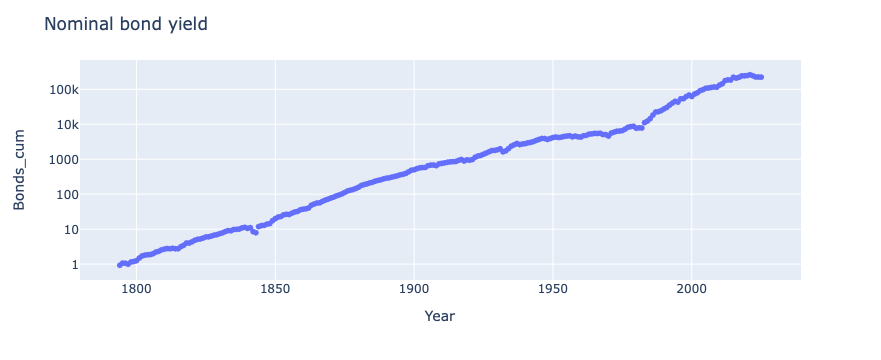

In [17]:
fig = px.scatter(df, x=df.index, y='Bonds_cum', log_y=True)
fig.update_layout(title="Nominal bond yield")

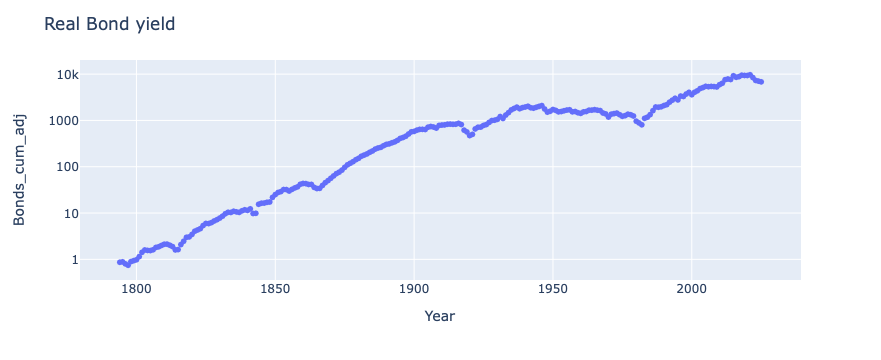

In [18]:
fig = px.scatter(df, x=df.index, y='Bonds_cum_adj', log_y=True)
fig.update_layout(title="Real Bond yield")

As expected, the bond chart ends up lower than stocks, achieving only 8,851 compared to 831,000 cumulative return. It may be shocking to see the bond chart so much lower - after all, the median annual yield of bonds was 5.5%, not much lower than the 8% of stocks. We must keep in mind, however, that these differences compound each year, which leads to a magnified effect over time.

The purpose of bonds in a portfolio is not to maximize return. Bonds are meant to minimize risk. In addition, no invester has a 200+ year investing horizon, and such a stark difference in returns would never be experienced in practice.

On the topic of minimizing risk, it is notable that inflation-adjusted bond yields experienced a flat period for much of the 1900's. 1 dollar invested in 1915 would have been worth only a dollar still in 1980. Stocks' real return curve never experienced anything like this. 

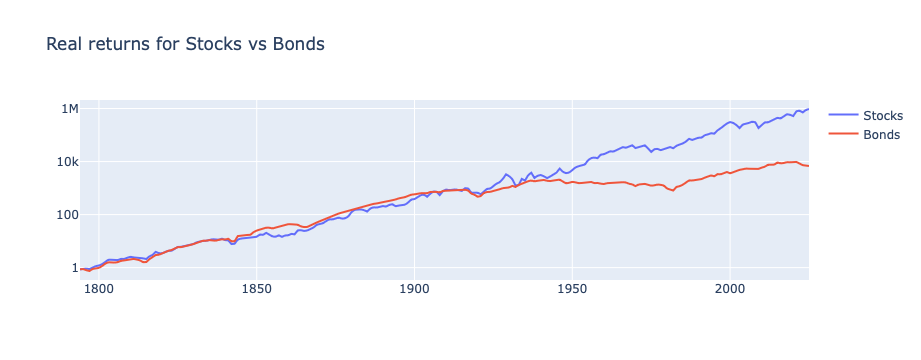

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Stocks_cum_adj'],
                    mode='lines',
                    name='Stocks'))
fig.add_trace(go.Scatter(x=df.index, y=df['Bonds_cum_adj'],
                    mode='lines',
                    name='Bonds'))
fig.update_yaxes(type='log')
fig.update_layout(title="Real returns for Stocks vs Bonds")
fig.show()

Above we can see the reason McQuarrie titled his paper "Stocks for the Long Run? Sometimes Yes. Sometimes No." Bonds outperformed for most of the 19th century.

The sheer magnitude of stocks' outperformance in the 20th century, however, is striking. 

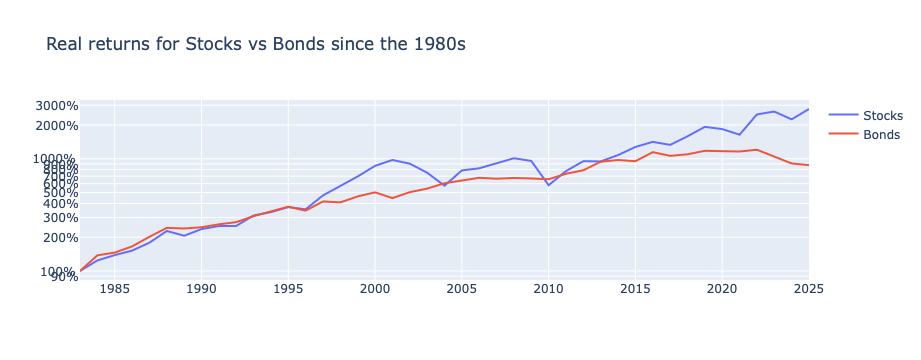

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[df.index > '1982-01-01'], y=df['Stocks_cum_adj'][df.index > '1981-01-01']/df.loc['1982-01-01']['Stocks_cum_adj'],
                    mode='lines',
                    name='Stocks'))
fig.add_trace(go.Scatter(x=df.index[df.index > '1982-01-01'], y=df['Bonds_cum_adj'][df.index > '1981-01-01']/df.loc['1982-01-01']['Bonds_cum_adj'],
                    mode='lines',
                    name='Bonds'))
fig.update_yaxes(type='log', tickformat=".0%")
fig.update_layout(title="Real returns for Stocks vs Bonds since the 1980s")
fig.show()

Since the 1980s, bonds have done a much better job keeping up, lagging only slightly.

The takeaway here is that, if not for the 1930's through the 1970's, bonds would have provided returns much closer to those of stocks overall. Yet again, the question of why is one for further research.

## Portfolio Simulation <a class="anchor" id="simulation"></a>

Now to the main purpose of this research - simulating returns of various portfolio allocations over 35-year periods. 

These allocations will be:

* 100\% stock
* 60\% stock - 40\% bond
* 40\% stock - 60\% bond
* 100\% bond

In [21]:
df['lump 100-0 return'] = (df['Stocks_cum_adj'] / df['Stocks_cum_adj'].shift(35))

df['lump 60-40 return'] = (df['Stocks_cum_adj'] / df['Stocks_cum_adj'].shift(35)) * 0.6 + \
                  (df['Bonds_cum_adj'] / df['Bonds_cum_adj'].shift(35)) * 0.4

df['lump 40-60 return'] = (df['Stocks_cum_adj'] / df['Stocks_cum_adj'].shift(35)) * 0.4 + \
                  (df['Bonds_cum_adj'] / df['Bonds_cum_adj'].shift(35)) * 0.6

df['lump 0-100 return'] = (df['Bonds_cum_adj'] / df['Bonds_cum_adj'].shift(35))

df.head()

,Inflation,Stocks,Bonds,Stocks_adj,Bonds_adj,Inflation_cum,Stocks_cum,Stocks_cum_adj,Bonds_cum,Bonds_cum_adj,lump 100-0 return,lump 60-40 return,lump 40-60 return,lump 0-100 return
Year,,,,,,,,,,,,,,
1794-01-01,7.3,-7.64,-7.24,-1.800000,-1.751807,1.073000,0.923600,0.860764,0.927600,0.864492,NaN,NaN,NaN,NaN
1795-01-01,12.8,19.81,15.32,0.507971,0.182609,1.210344,1.106565,0.914257,1.069708,0.883805,NaN,NaN,NaN,NaN
1796-01-01,9.5,9.90,-1.03,0.038095,-1.002857,1.325327,1.216115,0.917596,1.058690,0.798815,NaN,NaN,NaN,NaN
1797-01-01,0.6,-3.50,-6.10,-2.562500,-4.187500,1.333279,1.173551,0.880199,0.994110,0.745613,NaN,NaN,NaN,NaN
1798-01-01,-3.5,13.33,15.46,-6.732000,-7.584000,1.286614,1.329985,1.033710,1.147800,0.892109,NaN,NaN,NaN,NaN


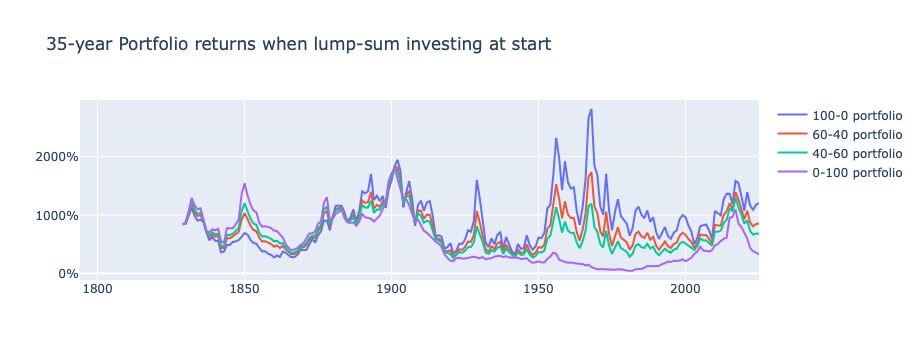

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['lump 100-0 return'],
                    mode='lines',
                    name='100-0 portfolio'))
fig.add_trace(go.Scatter(x=df.index, y=df['lump 60-40 return'],
                    mode='lines',
                    name='60-40 portfolio'))
fig.add_trace(go.Scatter(x=df.index, y=df['lump 40-60 return'],
                    mode='lines',
                    name='40-60 portfolio'))
fig.add_trace(go.Scatter(x=df.index, y=df['lump 0-100 return'],
                    mode='lines',
                    name='0-100 portfolio'))
fig.update_yaxes(tickformat=".0%")
#fig = px.line(df_new, x=df_new.index, y='100-0 return')
#fig.add_trace(line(df_new, x=df_new.index, y='60-40 return'))
fig.update_layout(title="35-year Portfolio returns when lump-sum investing at start")


fig.show()

Note how the 100% bond portfolio was top performer until 1880.

For the last 110 years, the 100% stock portfolio has come out ahead every time. 

Of course, the above is an oversimplified simulation. It represents investing your entire retirement savings up front and letting the money passively grow in the market, never adding to it (as I did in my first retirement account). This is *not* the recommended way to save for retirement.

For the final part of this report, we will create a modular function to visualize different portfolio results when making annual contributions. Even though the visualization should look very similar to the above, the function will allow us to enter real dollar amounts to see how the portfolio may have performed, vary the accumulation period, vary the allocation, etc. The reader will be able to change each variable to their satisfaction and see the result of doing so.

First we need to calculate an annualized return rate for each period. This can be given by the formula:

$$(\frac{Final value}{Starting value}^{\frac{1}{periods}} - 1) * 100$$

Then we need the formula for calculating returns when making periodic contributions (assuming no initial principal):

$$contribution * \frac{(1 + rate)^{periods + 1} - (1 + rate)}{rate}$$

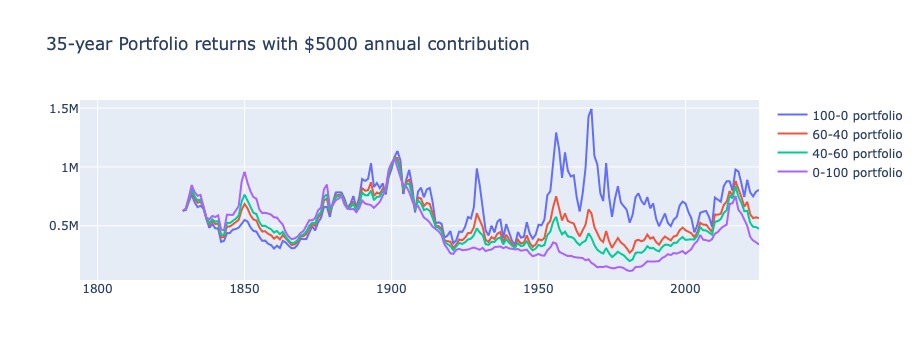

In [23]:
def simulator(df, contrib, periods, allocations):
    ''' 
    Visualizes portfolio returns given a DataFrame with inflation-adjusted cumulative returns for stocks and bonds, 
    accumulation period, annual contribution amount, and a list of portfolio allocations given as the fraction allocated to stocks
    ''' 
    assert isinstance(df, pd.core.frame.DataFrame), 'DataFrame not passed to function'
    assert ('Bonds_cum_adj' in df.columns) and ('Stocks_cum_adj' in df.columns), 'DataFrame must contain Stocks_cum_adj and Bonds_cum_adj'
    assert contrib > 0, 'Annual contributions must be positive number'
    assert periods > 0, 'Periods must be positive'
    assert type(allocations) == list, 'Allocations must be a list'
    for x in allocations:
        assert x >= 0, 'Allocations must be a positive number'
    
    # Calculate for each year the annualized return over the accumulation period
    df['trailing_stock_return_rate'] = ((df['Stocks_cum_adj'] / df['Stocks_cum_adj'].shift(periods))**(1/periods)-1) * 100
    df['trailing_bond_return_rate'] = ((df['Bonds_cum_adj'] / df['Bonds_cum_adj'].shift(periods))**(1/periods)-1) * 100
    
    fig = go.Figure()    
    
    for allocation in allocations:
        
        weighted_stock_rate = (1 + (df['trailing_stock_return_rate'] / 100)) * allocation
        weighted_bond_rate = (1 + (df['trailing_bond_return_rate'] / 100)) * (1-allocation)
        overall_rate = (weighted_stock_rate + weighted_bond_rate) - 1
        df[allocation*100] = contrib * ((1 + overall_rate)**(periods+1) - (1 + overall_rate)) / overall_rate
        
        # Plot the result
        fig.add_trace(go.Scatter(x=df.index, y=df[allocation*100], mode='lines', name='{}-{} portfolio'.format(int(allocation*100), int((1-allocation)*100))))
    
    fig.update_layout(title="{}-year Portfolio returns with ${} annual contribution".format(periods, contrib))
    fig.show()
    
    df_copy = df.copy()
    return df_copy
    
# Visualize a portfolio investing $5000/year across 35-year timespans with the 4 given allocations    
df_copy = simulator(df, 5000, 35, [1, .6, .4, 0])

Finally, let us look at a summary of our portfolio returns.

In [24]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

df_copy[[100, 60.0, 40.0, 0]].describe().loc[['min', '50%', 'max', 'std']]

,100,60.0,40.0,0
min,306324,271525,200207,115850
50%,632797,498969,456199,407753
max,1491746,1079807,1077399,1072601
std,222148,169552,183661,224636


## Conclusions <a class="anchor" id="conclusions"></a>

Across the history of the United States stock and bond markets, the median 100% stock portfolio returned 628,517 dollars while on the other end of the spectrum, the median 100% bond portfolio returned 33\% less at 421,096 dollars. 

Again, it is not surprising that stocks did better. But remember, bonds are added to hedge against the stock market and reduce portfolio risk and volatility. How do we put these results into that context?

### Risk and Reward
Risk is frequently defined as the standard deviation of an instrument. Earlier in this report, we saw the the standard deviation of real stocks returns was about 17 while real bond returns were about half that at 9. This accords with the common knowledge that bonds are lower risk instruments.

Another way to think of risk, when it is based on standard deviation, is simply as volatility. This makes sense in the context of retirement investing. As a person approaches retirement, they want to mitigate the odds of a large drawdown in their funds. Seeing their portfolio lose even 10% of its value could be very stressful and raise fears of continued losses. 

It is quite interesting that, in the table just above, the standard deviation of the 100% bond portfolio above came out a hair above the 100% stock portfolio. In these simulated portfolios based on the market's history, a full bond portflio showed showed a high risk / low return profile.

Another way to consider this is to look at the minimum return of the 100% stock portfolio - the worst case scenario. From the table above we can see it was 300,000 dollars - far above the worst-case scenario for any other portfolio, and nearly 3 times above the worst-case scenario of the bonds portfolio.

McQuarrie argued that in the 19th century bonds were a better investment whereas in the 20th century, stocks overtook that role. Given what we have shown above, however, the extended flat period of real bond yields in the 20th century had no parallel among stocks in the 19th century. In this light, we can say his argument overlooks this substantial risk in bonds. 

A mixed portfolio is the best choice, as it comes with lower risk than either extreme. Each individual will have to decide their own risk tolerance, but a stock-heavy portfolio with some bonds sprinkled has historically been a wise approach.

### Areas for Improvement and Further Research

While the above is a good beginning simulation for returns, it is incomplete because it does not account for taxes. Various avenues are available to lower the tax burden when selling stocks or bonds, particularly for retirement portfolios, such as IRAs (Individual Retirement Accounts). The first and perhaps most important area for improvement would be to evaluated tax-efficient strategies for maximizing portfolio returns. 

The above would also benefit from including global stocks and bonds. The US is a young nation compared to many others - the Amsterdam stock exchange is believed to go back to 1692, for example. 

Additional areas for further research have been noted throughout this report. 

## References <a class="anchor" id="references"></a>

Dore, K. (2021, August 21). *Workers’ savings just don’t match expected retirement income, survey finds*. CNBC.
&nbsp;&nbsp;&nbsp;&nbsp;https://www.cnbc.com/2021/08/31/workers-savings-dont-match-expected-retirement-income-survey-finds.html

Schiller, R. (2000). *Irrational Exuberance*. Broadway Books.

McQuarrie, E. (2021). *Stocks for the Long Run? Sometimes Yes. Sometimes No.*
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3805927

## Appendix: Unit Testing the Simulator <a class="anchor" id="appendix"></a>

The below testing was adapted from the course lectures and used during development of the portfolio simulation function.

In [ ]:
def test_exists():
    result = simulator(df, 1, 1, [1])
    return 1

def test_df():
    result = simulator(df, 1, 1, [1])    
    if isinstance(df, pd.core.frame.DataFrame):
        if ('Bonds_cum_adj' in df.columns) and ('Stocks_cum_adj' in df.columns):
            return 1
    else:
        return 0
    
def test_pos():
    result = simulator(df, -1, -1, [1])
    return 1
    
def test_list():
    result = simulator(df, 1, 1, ['a'])
    return 1

def test_list2():
    result = simulator(df, 1, 1, [-1])
    return 1
    
tests_passed = 0
tests_set = 5
    
tests_passed = tests_passed + test_exists()
tests_passed = tests_passed + test_df()
tests_passed = tests_passed + test_pos()
tests_passed = tests_passed + test_list()
tests_passed = tests_passed + test_list2()

print("tests: ", tests_set, "passed: ", tests_passed)